# Image processing with Spinal Cord Toolbox (SCT)

In this interactive notebook we will go through a series of processing steps specific to spinal cord MRI analysis. We first need to import the necessary tools and setup the filenames and folders in the notebook environment.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import os
from os.path import join
from IPython.display import clear_output

base_path = os.getcwd()

In [ ]:
# Download example data
!sct_download_data -d sct_example_data

# Go to MT folder
os.chdir('sct_example_data/mt/')

In [3]:
# Jupyter Notebook config
verbose = True # False clears cells

# Folder/filename config
parent_dirs = os.path.split(base_path)
mt_folder_relative = os.path.join('sct_example_data/mt')
qc_path = os.path.join(base_path, 'qc')

t1w = 't1w'
mt0 = 'mt0'
mt1 = 'mt1'
label_c3c4 = 'label_c3c4'
warp_template2anat = 'warp_template2anat'
mtr = 'mtr'
mtsat = 'mtsat'
t1map = 't1map'

file_ext = '.nii.gz'

if not verbose:
    clear_output()

The first processing step consists in segmenting the spinal cord. This is done automatically using an algorithm called [_Optic_](https://www.ncbi.nlm.nih.gov/pubmed/29288983) that finds the spinal cord centerline, followed by a second algorithm called [_DeepSeg-SC_](https://www.ncbi.nlm.nih.gov/pubmed/30300751) that relies on deep learning for segmenting the cord. 

In [ ]:
# Segment spinal cord
!sct_deepseg_sc -i {t1w+file_ext} -c t1 -qc {qc_path}

if not verbose:
    clear_output()

Results of the segmentation appear in Figure 1.

<p style="text-align:justify;">
<b>
Figure 1. Quality control (QC) SCT module segmentation results. The segmentation (in red) is overlaid on the T1-weighted anatomical scan (in grayscale). Orientation is axial.
</b>
</p>

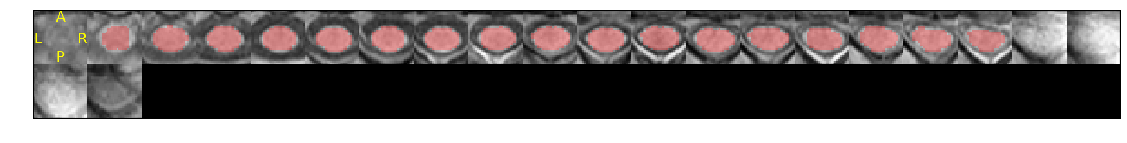

In [5]:
# Plot QC figures

if sys.platform == 'darwin':
    # For local testing on OSX    
    sct_deepseg_sc_qc = 'qc/sct_example_data/mt/sct_deepseg_sc'
else:
    # For linux and on-line Binder execution
    sct_deepseg_sc_qc = join(qc_path, parent_dirs[-1], mt_folder_relative, 'sct_deepseg_sc')

folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_deepseg_sc_qc, x)), os.listdir(sct_deepseg_sc_qc)))

qc_date = max(folders)

sct_deepseg_sc_qc_dir = join(sct_deepseg_sc_qc, qc_date)

bkg = mpimg.imread(join(sct_deepseg_sc_qc_dir, 'bkg_img.png'))
overlay = mpimg.imread(join(sct_deepseg_sc_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
plt.axis('off')
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

A zoomed-in snapshot of the QC-generated image is shown below.

<p>
<center><img src="segmentation.png" style="width:500px;height:auto;"></center>
</p>

Using the generated segmentation, we create a mask around the spinal cord which will be used to crop the image for faster processing and more accurate registration results: the registration algorithm will concentrate on the spinal cord and not on the surrounding tissue (e.g., muscles, neck fat, etc.) which could move independently from the spinal cord and hence produce spurious motion correction results.

In [ ]:
# Create mask
!sct_create_mask -i {t1w+file_ext} -p centerline,{t1w+'_seg'+file_ext} -size 35mm -o {t1w+'_mask'+file_ext}

# Crop data for faster processing
!sct_crop_image -i {t1w+file_ext} -m {t1w+'_mask'+file_ext} -o {t1w+'_crop'+file_ext}

if not verbose:
    clear_output()

Then, we register the proton density weighted (PD) image to the T1w image, and the MT-weighted image to the T1w image, so we end up with the T1w, MTw and PDw images all aligned together, which is a necessary condition for then computing quantitative MR metrics (here: MTsat).

In [ ]:
# Register PD->T1w
# Tips: here we only use rigid transformation because both images have very similar sequence parameters. We don't want to use SyN/BSplineSyN to avoid introducing spurious deformations.
!sct_register_multimodal -i {mt0+file_ext} -d {t1w+'_crop'+file_ext} -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

# Register MT->T1w
!sct_register_multimodal -i {mt1+file_ext} -d {t1w+'_crop'+file_ext} -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

if not verbose:
    clear_output()

Next step consists in registering the [PAM50 template](https://www.ncbi.nlm.nih.gov/pubmed/29061527) to the T1w image. We first create a label, centered in the spinal cord at level C3-C4 intervertebral disc, then we apply a multi-step non-linear registration algorithm.

In [ ]:
# Create label 4 at the mid-FOV, because we know the FOV is centered at C3-C4 disc.
!sct_label_utils -i {t1w+'_seg'+file_ext} -create-seg -1,4 -o {label_c3c4+file_ext}

# Register template->T1w_ax (using template-T1w as initial transformation)
!sct_register_to_template -i {t1w+'_crop'+file_ext} -s {t1w+'_seg'+file_ext} -ldisc {label_c3c4+file_ext} -ref subject -c t1 -param step=1,type=seg,algo=slicereg,metric=MeanSquares,smooth=2:step=2,type=im,algo=bsplinesyn,metric=MeanSquares,iter=5,gradStep=0.5 -qc {qc_path}

if not verbose:
    clear_output()

Once the PAM50 is registered with the T1w image, we can warp all objects pertaining to the PAM50 into the T1w native space. These objects notably include a [white matter atlas](https://www.ncbi.nlm.nih.gov/pubmed/26099457), which will be subsequently used to extract qMR metrics within specific white matter tracts.

In [ ]:
# Warp template
!sct_warp_template -d {t1w+'_crop'+file_ext} -w {warp_template2anat+file_ext} -qc {qc_path}

if not verbose:
    clear_output()

<p style="text-align:justify;">
<b>
Figure 2. Quality control (QC) SCT module registration/warping results of the PAM50 template and atlas to the T1w native space. The white matter (in blue) is overlaid on the T1-weighted anatomical scan (in grayscale). Orientation is axial. 
</b>
</p>

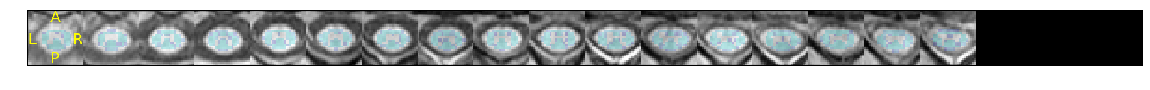

In [10]:
# Plot QC figures
if sys.platform == 'darwin':
    # For local testing on OSX    
    sct_warp_template_qc = 'qc/sct_example_data/mt/sct_warp_template'
else:
    # For linux and on-line Binder execution
    sct_warp_template_qc = join(qc_path, parent_dirs[-1],  mt_folder_relative, 'sct_warp_template')

folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_warp_template_qc, x)), os.listdir(sct_warp_template_qc)))
qc_date = max(folders)

sct_warp_template_qc_dir = join(sct_warp_template_qc, qc_date)

bkg = mpimg.imread(join(sct_warp_template_qc_dir, 'bkg_img.png'))
overlay = mpimg.imread(join(sct_warp_template_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
plt.axis('off')
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

A zoomed-in snapshot of the QC-generated warped 

<p>
<center><img src="warp.png" style="width:500px;height:auto;"></center>
</p>

Once co-registration between images and registration to the template is complete, we can venture into computing our favorite qMR metrics. Here, we compute the magnetization transfer ratio (MTR) and the magnetization transfer saturation (MTsat).

In [ ]:
# Compute MTR
!sct_compute_mtr -mt1 {mt1+'_reg'+file_ext} -mt0 {mt0+'_reg'+file_ext}

# Compute MTsat and T1
!sct_compute_mtsat -mt {mt1+'_reg'+file_ext} -pd {mt0+'_reg'+file_ext} -t1 {t1w+'_crop'+file_ext} -trmt 57 -trpd 57 -trt1 15 -famt 9 -fapd 9 -fat1 15

if not verbose:
    clear_output()

Now that our metrics are computed, we want to extract their values within specific tracts of the spinal cord. This is done with the function `sct_extract_metric`.

In [ ]:
# Extract MTR, MTsat and T1 in WM between C2 and C4 vertebral levels
!sct_extract_metric -i mtr.nii.gz -l 51 -vert 2:4 -perlevel 1 -o mtr_in_wm.csv
!sct_extract_metric -i mtsat.nii.gz -l 51 -vert 2:4 -perlevel 1 -o mtsat_in_wm.csv
!sct_extract_metric -i t1map.nii.gz -l 51 -vert 2:4 -perlevel 1 -o t1_in_wm.csv

if not verbose:
    clear_output()

Results are output as csv files, which we can then open and display as bar graphs.

<p style="text-align:justify;">
<b>
Figure 3. Quantitative MRI metrics in WM between C2 and C4 vertebral levels. The three calculated metrics from this dataset using SCT are the magnetization transfer ratio (MTR – [%]), magnetization transfer saturation (MTsat – [a.u.]), and longitudinal relaxation time (T1 – [s]).
</b>
</p>

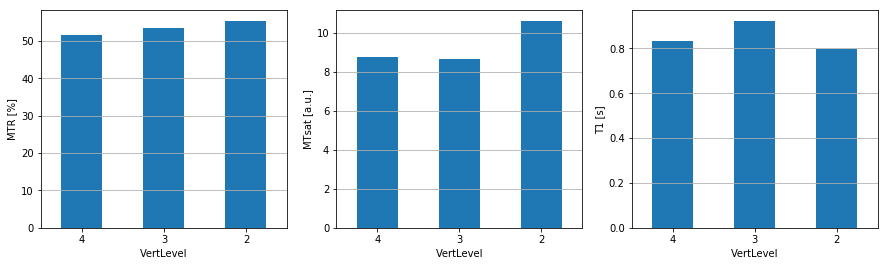

In [13]:
# Display plots of results
import pandas as pd
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

# Build dic for plot
plot_dic = {'file': ['mtr_in_wm.csv', 'mtsat_in_wm.csv', 't1_in_wm.csv'],
            'ylabel': ['MTR [%]', 'MTsat [a.u.]', 'T1 [s]']}

# Loop across dic entries
for i in range(len(plot_dic)+1):
    df = pd.read_csv(plot_dic['file'][i])
    df.plot.bar(x='VertLevel', y='WA()', rot=0, ax=ax[i], legend=False)
    ax[i].set_ylabel(plot_dic['ylabel'][i])
    ax[i].yaxis.grid()